In [58]:
from Bio import SeqIO
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import numpy as np


r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0;

# define universe of possible input values
alphabet = 'OARNDCQEGHILKMFPSTWYV'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

i = 0
#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            print(data, i)
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("./Datasets/training_data/ecoli_train.fasta", "fasta"):

    innertest1()
    i += 1
    
#print(len(r_test_x))

#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded) 
    r_test_y.append(negat_0)

for seq_record in SeqIO.parse("./Datasets/training_data/ecoli_train_neg.fasta", "fasta"):
    innertest2()
# Changing to array (matrix)    
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)

# Balancing test dataset
# Testing Data Balancing by undersampling####################################
# trộn dữ liệu
rus = RandomUnderSampler(random_state=7)
x_res3, y_res3 = rus.fit_resample(r_test_x, r_test_y)
#Shuffling
r_test_x, r_test_y = shuffle(x_res3, y_res3, random_state=7)
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)
#print(r_test_y.shape)
r_test_x = np.expand_dims(r_test_x, 1)
print(r_test_x.shape)


(2906, 1, 25)


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DLMal(nn.Module):
    def __init__(self):
        super(DLMal, self).__init__()
        self.embedding = nn.Embedding(25,21)
        self.conv1 = nn.Conv2d(1, 64, (15, 3))
        self.dropout1 = nn.Dropout(0.6)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.dropout2 = nn.Dropout(0.6)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4096, 768)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(768, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.embedding(x)
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = self.dropout2(x)
        x = self.maxpool(x)
        #print(x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        return self.fc3(x)
net = DLMal()
y = net(torch.from_numpy(np.array([r_test_x[0]])))#convert array numpy to tensor
print(y)
print(r_test_y)

tensor([[-0.1554, -0.0391]], grad_fn=<AddmmBackward>)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [59]:
import torch
from torch.utils.data import Dataset

class MALDataset(Dataset):
    def __init__(self, r_test_x, r_test_y):
        self.r_test_x = r_test_x
        self.r_test_y = r_test_y

    def __len__(self):
        return len(self.r_test_x)

    def __getitem__(self, idx):
        data = torch.from_numpy(np.array(r_test_x[idx]))
        label = [[1,0],[0,1]]
        label = torch.from_numpy(np.array(label[r_test_y[idx]], dtype='float32'))
        return data, label

ratio = 0.7

trainset = MALDataset(r_test_x[:int(len(r_test_x)*ratio)], r_test_y[:int(len(r_test_y)*ratio)])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

valset = MALDataset(r_test_x[int(len(r_test_x)*ratio):], r_test_y[int(len(r_test_y)*ratio):])
valloader = torch.utils.data.DataLoader(valset, batch_size=128,
                                          shuffle=True, num_workers=4)
# Define a Loss function and optimizer
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_accs = []
train_losses = []
val_accs = []
val_losses = []


#Train the network
for epoch in range(50):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    train_acc = 0.0
    train_tot_acc = 0
    train_tot_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        outputs = outputs[:,1] > outputs[:,0]
        labels = labels[:,1] > labels[:,0]
        acc = np.sum(outputs.astype("int32") == labels.astype("int32"))/len(labels)
#         print(outputs.astype('int32'), labels.astype("int32"))
        train_acc += acc
        # print statistics
        running_loss += loss.item()
        train_tot_loss += loss.item()
        train_tot_acc += acc
        if i % 1 == 0: 
            print('[%d, %5d] train loss: %.3f train acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1, train_acc/ 1))
            running_loss = 0.0
            train_acc = 0.0
    
    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        outputs = F.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        outputs = outputs[:,1] > outputs[:,0]
        labels = labels[:,1] > labels[:,0]
        acc = np.sum(outputs.astype("int32") == labels.astype("int32"))/len(labels)
        val_acc += acc
    print('[%d] val loss: %.3f val acc: %.3f' %
              (epoch + 1, val_loss / len(valloader), val_acc/len(valloader)))
    train_accs.append(train_tot_acc/len(trainloader))
    train_losses.append(train_tot_loss/len(trainloader))
    val_accs.append(val_acc / len(valloader))
    val_losses.append(val_loss / len(valloader))

PATH = './Path/dlmal_e_net.pth'
torch.save(net, PATH)

print('Finished Training')

[1,     1] train loss: 0.085 train acc: 0.973
[1,     2] train loss: 0.075 train acc: 0.969
[1,     3] train loss: 0.093 train acc: 0.965
[1,     4] train loss: 0.060 train acc: 0.980
[1,     5] train loss: 0.082 train acc: 0.965
[1,     6] train loss: 0.067 train acc: 0.980
[1,     7] train loss: 0.089 train acc: 0.969
[1,     8] train loss: 0.104 train acc: 0.959
[1] val loss: 0.006 val acc: 1.000
[2,     1] train loss: 0.061 train acc: 0.977
[2,     2] train loss: 0.053 train acc: 0.980
[2,     3] train loss: 0.135 train acc: 0.969
[2,     4] train loss: 0.137 train acc: 0.957
[2,     5] train loss: 0.172 train acc: 0.953
[2,     6] train loss: 0.090 train acc: 0.965
[2,     7] train loss: 0.060 train acc: 0.984
[2,     8] train loss: 0.070 train acc: 0.967
[2] val loss: 0.014 val acc: 1.000
[3,     1] train loss: 0.080 train acc: 0.961
[3,     2] train loss: 0.073 train acc: 0.973
[3,     3] train loss: 0.108 train acc: 0.969
[3,     4] train loss: 0.156 train acc: 0.965
[3,     5]

[21,     2] train loss: 0.049 train acc: 0.988
[21,     3] train loss: 0.083 train acc: 0.977
[21,     4] train loss: 0.070 train acc: 0.977
[21,     5] train loss: 0.073 train acc: 0.969
[21,     6] train loss: 0.111 train acc: 0.973
[21,     7] train loss: 0.095 train acc: 0.965
[21,     8] train loss: 0.107 train acc: 0.950
[21] val loss: 0.022 val acc: 1.000
[22,     1] train loss: 0.080 train acc: 0.961
[22,     2] train loss: 0.073 train acc: 0.973
[22,     3] train loss: 0.056 train acc: 0.984
[22,     4] train loss: 0.057 train acc: 0.984
[22,     5] train loss: 0.080 train acc: 0.973
[22,     6] train loss: 0.080 train acc: 0.973
[22,     7] train loss: 0.117 train acc: 0.945
[22,     8] train loss: 0.058 train acc: 0.983
[22] val loss: 0.032 val acc: 1.000
[23,     1] train loss: 0.091 train acc: 0.965
[23,     2] train loss: 0.118 train acc: 0.965
[23,     3] train loss: 0.065 train acc: 0.984
[23,     4] train loss: 0.045 train acc: 0.992
[23,     5] train loss: 0.084 train

[41,     1] train loss: 0.040 train acc: 0.980
[41,     2] train loss: 0.076 train acc: 0.977
[41,     3] train loss: 0.075 train acc: 0.980
[41,     4] train loss: 0.060 train acc: 0.980
[41,     5] train loss: 0.042 train acc: 0.980
[41,     6] train loss: 0.127 train acc: 0.965
[41,     7] train loss: 0.090 train acc: 0.961
[41,     8] train loss: 0.116 train acc: 0.955
[41] val loss: 0.016 val acc: 1.000
[42,     1] train loss: 0.067 train acc: 0.980
[42,     2] train loss: 0.105 train acc: 0.953
[42,     3] train loss: 0.113 train acc: 0.969
[42,     4] train loss: 0.050 train acc: 0.980
[42,     5] train loss: 0.099 train acc: 0.969
[42,     6] train loss: 0.047 train acc: 0.984
[42,     7] train loss: 0.045 train acc: 0.984
[42,     8] train loss: 0.069 train acc: 0.975
[42] val loss: 0.021 val acc: 1.000
[43,     1] train loss: 0.080 train acc: 0.961
[43,     2] train loss: 0.057 train acc: 0.980
[43,     3] train loss: 0.076 train acc: 0.977
[43,     4] train loss: 0.071 train

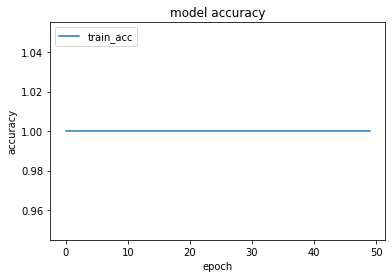

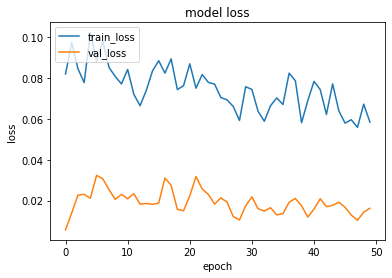

In [60]:
from matplotlib import pyplot as plt
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [63]:
r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0; #dinh nghĩa label

# define universe of possible input values
alphabet = 'OARNDCQEGHILKMFPSTWYV'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

i = 0
#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("./Datasets/independent_data/ecoli_test.fasta", "fasta"):

    innertest1()
    i += 1


#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
#             print(data, i)
            return
    integer_encoded = [char_to_int[char] for char in data]
    if integer_encoded[0] == 6: print(data, int_to_char[6], len(r_test_x))
    r_test_x.append(integer_encoded) 
    r_test_y.append(negat_0)

for seq_record in SeqIO.parse("./Datasets/independent_data/ecoli_test_neg.fasta", "fasta"):
    innertest2()
# Changing to array (matrix)    
r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)

# Balancing test dataset
# Testing Data Balancing by undersampling####################################
# rus = RandomUnderSampler(random_state=7)
# x_res3, y_res3 = rus.fit_resample(r_test_x, r_test_y)
# #Shuffling
# r_test_x, r_test_y = shuffle(x_res3, y_res3, random_state=7)
# r_test_x = np.array(r_test_x)
# r_test_y = np.array(r_test_y)

r_test_x = np.expand_dims(r_test_x, 1)
print(r_test_x.shape)
print(r_test_x)
print(r_test_y)

LYTKYEKDDSIRKQRVKAVELFSLM
GIGVINFAYYLAKHGKRYSDGSANN
HMQIINEINTRFKTLVEKTWPGDEK
ILEANLLPPPEPKESWRRIMDELSV
TYFGELSRMTQFKDKSARYAENINA
KEILGDEADQYVKVPDTLDVWFDSG
AIQFAWELLTSEKWFALPKERLWVT
AALASVKGWVSAKLQOOOOOOOOOO
PIQETITFDDFAKVDLRVALIENAE
ERGKVIADYEERKAKIKADAEEAAR
RAALGVLRIIVEKNLNLDLQTLTEE
IRQIIDEDLASGKHTTVHTRFPPEP
KVISVQEMHAQIKOOOOOOOOOOOO
OOOOOOOOOMKIKTRFAPSPTGYLH
WDAAQSLLATYIKLNVARHQQGQPL
CGTAMDSYLIDPKRKLHVCGNNPTC
DAREAFLNITVTKDSRTRYSEAGHP
MATGSYPWIPPIKGSDTQDCFVYRT
EIYKRLIVSEDNKTLLGAVLVGDTS
TFIATSPMHIATKLRSTLDEVIERA
ISGLYERVPNIDKAIISVHTHDDLG
RNGLRPARYVITKDKLITCASEVGI
ADVIQIKVAQGAKPGEGGQLPGDKV
PAPCDYAITAIQKFLETDIPVFGIC
LPEQVRTNADLEKMVDTSDEWIVTR
LVDDERWARFNEKLENIERERQRLK
AAGDEVTVVRDEKKAREVALYRQGK
QLGIVSLREALEKAEEAGVDLVEIS
QLGIVSLREALEKAEEAGVDLVEIS Q 127
VGEDWISLDMHGKRPKAVNVRTAPH
OOOMSLLNVPAGKDLPEDIYVVIEI
OOOOOOOOOOOMKPYQRQFIEFALS
FGRPQRVAQEMQKEIALILQREIKD
AAALGQIEKQFGKGSIMRLGEDRSM
HTTIGKVDFDADKLKENLEALLVAL
KQYDINEAIALLKELATAKFVESVD
VRQHVIYKEAKIKOOOOOOOOOOOO
RAKYQRQLARAIKRARYLSLLPYTD
AFAVIV

In [64]:
#nạp mangjg đã train
#############################################
PATH = './Path/dlmal_e_net.pth'
net = torch.load(PATH, map_location="cpu")
net.eval()
################################################3
print(r_test_x[0])
print([int_to_char[i] for i in r_test_x[0][0]])
y = net(torch.from_numpy(np.array([r_test_x[0]])))
print(F.softmax(y, dim=1))

print(r_test_x[-1])
print([int_to_char[i] for i in r_test_x[-1][0]])
y = net(torch.from_numpy(np.array([r_test_x[-1]])))
print(F.softmax(y, dim=1))

TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(r_test_x)):
    y = net(torch.from_numpy(np.array([r_test_x[i]])))
    y = F.softmax(y, dim=1)
    y = y.detach().cpu().numpy()
    if (y[0][0] > y[0][1] and r_test_y[i] == 0):
        TN += 1
    elif (y[0][0] < y[0][1] and r_test_y[i] == 1):
        TP += 1
    elif r_test_y[i] == 0:
        FN += 1
        print([int_to_char[i] for i in r_test_x[i][0]], y)
    else:
        FP +=1
        print([int_to_char[i] for i in r_test_x[i][0]], y)
       
print("acc:", (TP+TN)/(TP+TN+FP+FN)*100)
print("sn:", (TP)/(TP+FN)*100)
print("sp:", TN/(TN+FP)*100)
print("mcc:", (TP*TN-FP*FN)/((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**(1/2))

[[11  7 13  1  6  3  1  1  2 11  8 18 12  1  7 12 20  4  1  2 11  9  9 10
  13]]
['L', 'E', 'M', 'A', 'Q', 'N', 'A', 'A', 'R', 'L', 'G', 'W', 'K', 'A', 'E', 'K', 'V', 'D', 'A', 'R', 'L', 'H', 'H', 'I', 'M']
tensor([[0.6297, 0.3703]], grad_fn=<SoftmaxBackward>)
[[14  7 10 20  3  3  7 16  4 15  2 14 12  7 19 18 17  7 19 14  6 10 13 12
   2]]
['F', 'E', 'I', 'V', 'N', 'N', 'E', 'S', 'D', 'P', 'R', 'F', 'K', 'E', 'Y', 'W', 'T', 'E', 'Y', 'F', 'Q', 'I', 'M', 'K', 'R']
tensor([[0.9982, 0.0018]], grad_fn=<SoftmaxBackward>)
['L', 'E', 'M', 'A', 'Q', 'N', 'A', 'A', 'R', 'L', 'G', 'W', 'K', 'A', 'E', 'K', 'V', 'D', 'A', 'R', 'L', 'H', 'H', 'I', 'M'] [[0.62969226 0.3703077 ]]
['A', 'A', 'A', 'N', 'K', 'R', 'V', 'S', 'N', 'I', 'L', 'A', 'K', 'S', 'D', 'E', 'V', 'L', 'S', 'D', 'R', 'V', 'N', 'A', 'S'] [[0.8890437  0.11095636]]
['R', 'R', 'L', 'Q', 'A', 'R', 'L', 'E', 'A', 'L', 'G', 'I', 'K', 'T', 'L', 'L', 'C', 'D', 'P', 'P', 'R', 'A', 'D', 'R', 'G'] [[0.6924589  0.30754113]]
['D', 'E', 'F', 'A', '

['E', 'A', 'M', 'A', 'M', 'A', 'K', 'R', 'V', 'S', 'K', 'L', 'K', 'N', 'A', 'N', 'R', 'F', 'F', 'V', 'A', 'S', 'D', 'V', 'H'] [[0.00492229 0.9950777 ]]
['P', 'L', 'G', 'E', 'E', 'E', 'V', 'A', 'L', 'A', 'R', 'Q', 'K', 'L', 'G', 'W', 'H', 'H', 'P', 'P', 'F', 'E', 'I', 'P', 'K'] [[0.19810833 0.8018917 ]]
['L', 'A', 'Q', 'E', 'E', 'V', 'W', 'I', 'R', 'Q', 'G', 'I', 'K', 'A', 'R', 'R', 'T', 'R', 'N', 'E', 'G', 'R', 'V', 'R', 'A'] [[0.1397476 0.8602524]]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'M', 'Q', 'K', 'V', 'V', 'L', 'A', 'T', 'G', 'N', 'V', 'G', 'K', 'V', 'R'] [[0.47485703 0.52514297]]
['P', 'H', 'K', 'S', 'P', 'E', 'V', 'F', 'N', 'L', 'I', 'M', 'K', 'R', 'R', 'A', 'I', 'A', 'G', 'S', 'M', 'I', 'G', 'G', 'I'] [[0.0348836 0.9651164]]
['K', 'V', 'A', 'L', 'A', 'Q', 'A', 'Q', 'G', 'Q', 'L', 'A', 'K', 'D', 'K', 'A', 'T', 'L', 'A', 'N', 'A', 'R', 'R', 'D', 'L'] [[0.16091985 0.83908015]]
acc: 63.5
sn: 64.83516483516483
sp: 62.38532110091744
mcc: 0.2711001881729744
